# __1. Compréhension et analyse des données__

### **1.1 Données du Challenge**

$But$

Le challenge que nous proposons consiste à reconstruire les données manquantes de certaines courbes de consommation électrique en utilisant uniquement d’autres courbes de consommation électrique.
Nous avons utilisé un outil de génération de courbes synthétiques, DeepCourbogen, pour générer environ 69 000 courbes. 1 000 de ces courbes ont subi des suppressions aléatoires de données, pour simuler les données manquantes de courbes réelles.

Le but des challengers est de proposer des remplacements pour les données manquantes (« remplir les trous ») dans les 1 000 courbes.
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

$Description des données$

Pour l’échantillon d’entrainement :

- la donnée d’entrée est une dataframe de 21 000 colonnes. Chacune d’entre elles est une courbe synthétique générée par DeepCourbogen. Chaque nom de colonne est un identifiant () généré aléatoirement. L’index de la dataframe est le timestamp de chaque point, les valeurs de consommation sont en watts. Les 1 000 dernières colonnes contiennent les courbes auquelles il manque des données. Les noms de ces colonnes sont de la forme holed_
- La donnée de sortie est une dataframe de 1 000 colonnes contenant les données complétées des 1 000 dernières colonnes des données d’entrée.
Le fichier d’entrée fait 140 Mo, le fichier de sortie 6 Mo.

Pour l’échantillon de test, la donnée d’entrée est une dataframe de 38140 colonnes (260 Mo), la donnée de sortie fait toujours 1000 colonnes (6 Mo)
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

### **1.2 Extraction des données**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Échantillon d'entraînement
df_X_train = pd.read_csv('X_train_78VdSWL.csv') # Donnée d’entrée, dataframe de 21 000 (140 Mo)
Y_train = pd.read_csv('y_train_u0UkKEh.csv') # Donnée de sortie, 1000 colonnes manquantes (6 Mo)

# Échantillon de test
df_X_test = pd.read_csv('X_test_XKVc4no.csv') # Donnée d’entrée, dataframe de 38140 colonnes (260 Mo)
Y_test = pd.read_csv('new_output_sample.csv') # Donnée de sortie, 1000 colonnes manquantes (6 Mo)

### **1.3 Modélisation d'une courbe**

In [2]:
df_X_train.columns

Index(['Horodate', '5423908671', '2568793410', '8310762594', '6235194807',
       '423895617', '193845276', '216589743', '218753964', '1794650328',
       ...
       'holed_991', 'holed_992', 'holed_993', 'holed_994', 'holed_995',
       'holed_996', 'holed_997', 'holed_998', 'holed_999', 'holed_1000'],
      dtype='object', length=21001)

On affiche à l'écran le nom de chaque colonne de df_X_train pour pouvoir sélectionner celle que l'on souhaite.

On sélectionne la colonne 'holed_1000' car d'après l'énoncé, c'est une courbe avec des données manquantes.

In [3]:
df_X_test['holed_1000']

0       129.0
1       113.0
2         NaN
3       135.0
4         NaN
        ...  
1052      NaN
1053     78.0
1054     57.0
1055     49.0
1056     42.0
Name: holed_1000, Length: 1057, dtype: float64

On observe bien qu'il y a des valeurs manquante (NaN = une valeur manquante).

Affichons la courbe de données de la colonne holed_1000.

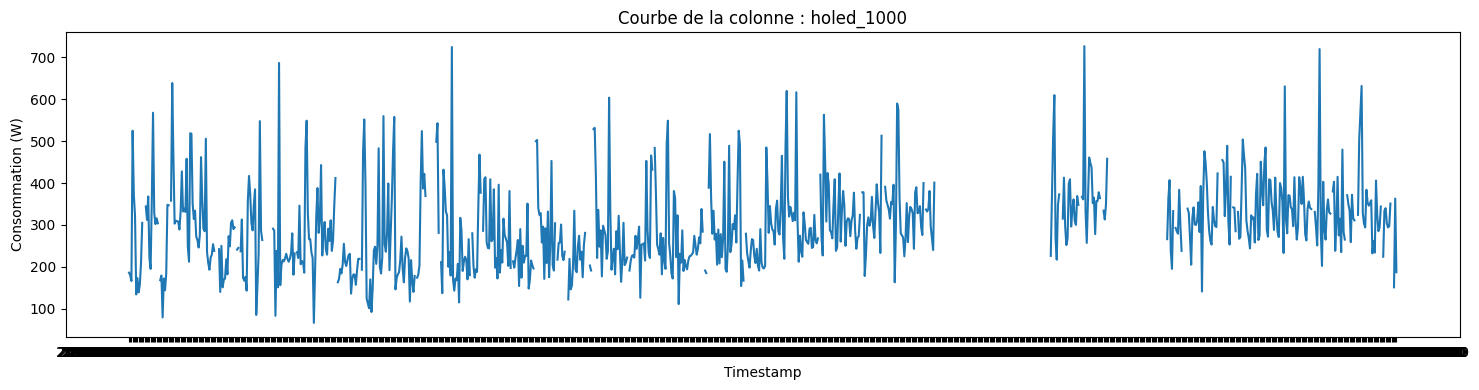

In [4]:
X = df_X_train['Horodate']
Y_holed1000 = df_X_train['holed_1000']
plt.figure(figsize=(15, 4))
plt.plot(X, Y_holed1000)
plt.title("Courbe de la colonne : holed_1000")
plt.xlabel('Timestamp')
plt.ylabel('Consommation (W)')
plt.tight_layout()
plt.show()


#Problème d'affichage des abscisses...

On observe bien sur la courbe qu'il y a des espaces vides, notre but sera de faire des estimations avec le moins d'erreur possibles pour essayer de remplir ses epaces.

### **1.4 MAE**
Pour calculer notre erreur nous allons faire une fonction MAE (Erreur Absolue Moyenne) que nous utiliserons dès que nous voudrons évaluer nos estimations. La MAE est la moyenne des erreurs absolues ramenée au nombre réel de valeurs manquantes.

In [5]:
from sklearn.metrics import mean_absolute_error

def MAE(Y_reel, Y_pred):
    mae = mean_absolute_error(Y_reel, Y_pred)
    return mae

### **1.5 Benchmark sur la courbe**

Dans l'énoncé du Challenge, on nous donne comme exemple un "Benchmark" basique consistant à faire de l’interpolation linéaire sur les données manquantes. On a la fonction suivante :

In [6]:
def fill_nan_with_interpolation(column):
    col = column.copy()
    col = col.interpolate(method='linear', limit_direction='both')
    return col

Essayer de l'utiliser pour modéliser le Benchmark.

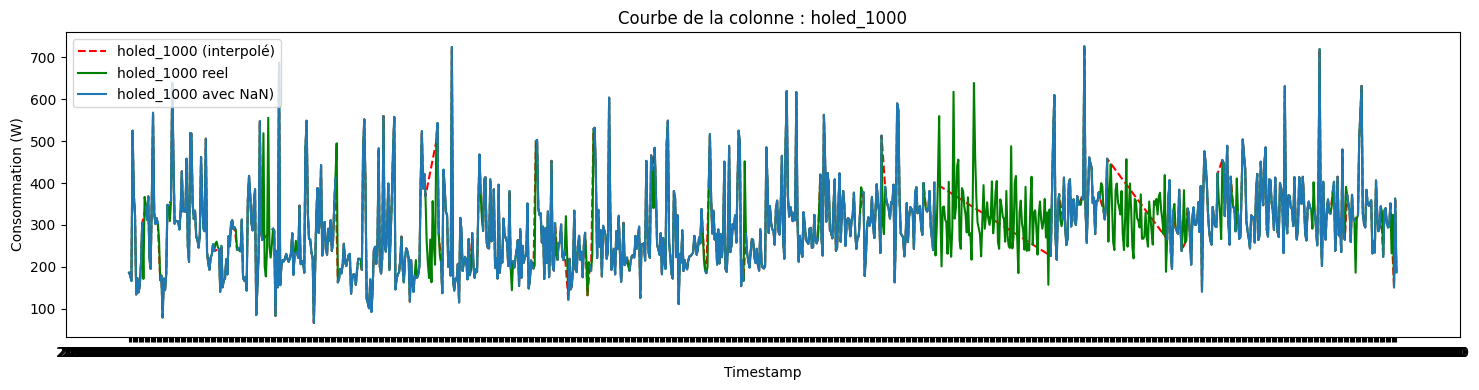

In [7]:
Y_pred_holed1000 = fill_nan_with_interpolation(Y_holed1000)
Y_reel_holed1000 = Y_train['holed_1000']

# Visualisation
plt.figure(figsize=(15, 4))
plt.plot(X, Y_pred_holed1000, 'r--', label="holed_1000 (interpolé)")
plt.plot(X, Y_reel_holed1000, 'g', label="holed_1000 reel")
plt.plot(X, Y_holed1000, label="holed_1000 avec NaN)")
plt.title("Courbe de la colonne : holed_1000")
plt.xlabel('Timestamp')
plt.ylabel('Consommation (W)')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
mae = MAE(Y_reel_holed1000,Y_pred_holed1000)
print(f"MAE du modèle : {mae:.4f}")

MAE du modèle : 15.1421


On obtient le résultat mais pour une courbe, il faudrait essayer de le faire pour toute les courbes qui ont des données manquantes.

### **1.6 Benchmark pour toutes les courbes**

In [9]:
for idx,column in enumerate(df_X_train.columns):
    print(idx,column)

0 Horodate
1 5423908671
2 2568793410
3 8310762594
4 6235194807
5 423895617
6 193845276
7 216589743
8 218753964
9 1794650328
10 9253476180
11 3917465028
12 3974605218
13 7805236914
14 6259187403
15 1879425630
16 8639751240
17 795213846
18 2197845603
19 5703821469
20 5386901274
21 2736540981
22 6295784031
23 2579186034
24 5047326819
25 163894257
26 4213906578
27 9084523167
28 2769850143
29 852791643
30 9142735860
31 4025986317
32 9524706813
33 8527394601
34 8417206539
35 3704156892
36 8367149052
37 6802349175
38 3258790164
39 1408926735
40 9024756381
41 2341857069
42 9580267134
43 3805461729
44 7548093162
45 7206385491
46 4915632087
47 2870914536
48 6842095317
49 7296341805
50 6592380471
51 2509748613
52 1489723065
53 6817523940
54 4286391570
55 8673120954
56 8430576912
57 4358602917
58 1785430296
59 9237045618
60 5906172843
61 5268913704
62 4157963802
63 5087912364
64 649217385
65 492165738
66 7613258490
67 5483902761
68 8402597631
69 3740825169
70 1486370592
71 3568170249
72 4950312678

On doit sélectionner les colonnes d'indice 20 001 à 21 000 pour avoir les 1000 dernières colonnes qui ont des données manquantes.

In [10]:
Y_train['holed_192']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1052   NaN
1053   NaN
1054   NaN
1055   NaN
1056   NaN
Name: holed_192, Length: 1057, dtype: float64

__Pourquoi c'est la seul qui est vide ? Y_train n'est pas les Y réel ?__ 

In [11]:
import numpy as np

j = 0
Liste_mae_train = []
for i in range (20001,20192):
    Y_origin_train = df_X_train.iloc[:,i]
    Y_pred_train = fill_nan_with_interpolation(Y_origin_train)
    Y_reel_train = Y_train.iloc[:,j+1]
    Liste_mae_train.append(MAE(Y_reel_train,Y_pred_train))
    j += 1
j+=1
for i in range (20193,21001):
    Y = df_X_train.iloc[:,i]
    Y_pred_train = fill_nan_with_interpolation(Y_origin_train)
    Y_reel_train = Y_train.iloc[:,j+1]
    Liste_mae_train.append(MAE(Y_reel_train,Y_pred_train))
    j += 1

moyenne_mae_train = np.average(Liste_mae_train)
print(f"Moyenne des MAE des données de l'échantillon d'entraînement : {moyenne_mae_train:.4f}")


Moyenne des MAE des données de l'échantillon d'entraînement : 278.7648


__Je voulais retrouver le score du Benchamrk sur le site : 104,5369 Mais ce n'est pas le cas...__

__Le problème est peut-être dûe au fait que le Score indiqué sur le tableau n'est pas exactement la MAE... et ça expliquerait pourquoi en publique c'est 104,5369 alors qu'en privé c'est 107,4901__

In [12]:
j = 0
Liste_mae_test = []
for i in range (20001,21001):
    Y_origin_test = df_X_test.iloc[:,i]
    Y_pred_test = fill_nan_with_interpolation(Y_origin_test)
    Y_reel_test = Y_test.iloc[:,j+1]
    Liste_mae_test.append(MAE(Y_reel_test,Y_pred_test))
    j += 1

moyenne_mae_test = np.average(Liste_mae_test)
print(f"Moyenne des MAE des données échantillon de test : {moyenne_mae_test:.4f}")

Moyenne des MAE des données échantillon de test : 2730.3789


__Au cas ou ce n'est pas le benchmark des données test...__

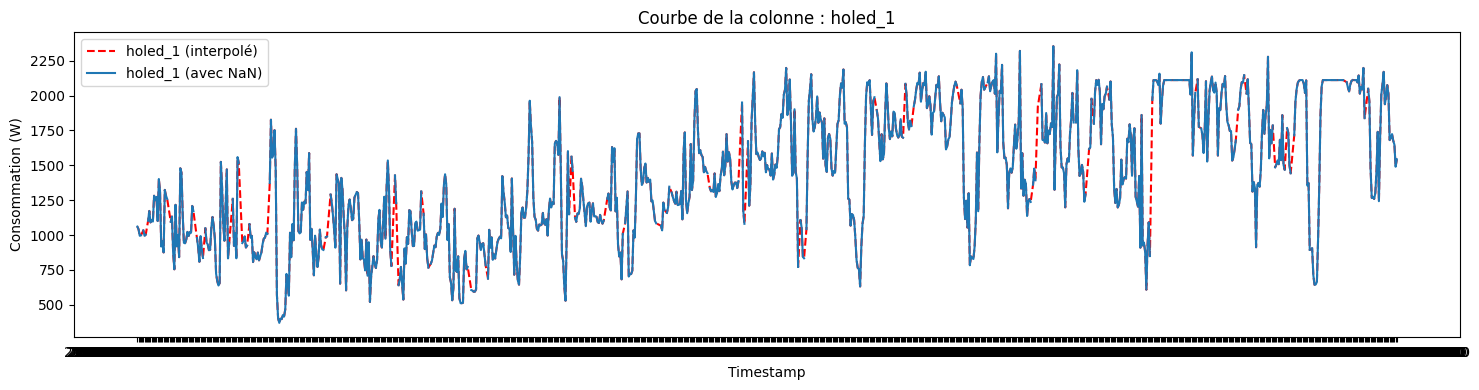

In [13]:
X = df_X_test['Horodate']
Y_holed1 = df_X_test['holed_1']
Y_pred_holed1 = fill_nan_with_interpolation(Y_holed1)
Y_reel_holed1 = Y_test['holed_1']

plt.figure(figsize=(15, 4))
plt.plot(X, Y_pred_holed1, 'r--', label="holed_1 (interpolé)")
#plt.plot(X, Y_reel, 'g', label='holed_1 (reel)')
plt.plot(X, Y_holed1, label="holed_1 (avec NaN)")
plt.title("Courbe de la colonne : holed_1")
plt.xlabel('Timestamp')
plt.ylabel('Consommation (W)')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
mae = MAE(Y_reel_holed1,Y_pred_holed1)
print(f"MAE du modèle : {mae:.4f}")

MAE du modèle : 1952.1122


# __2. Test de nouvelles estimations__

__La faut faire des calculs pour avoir le meilleur score possible...__